In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from scipy import sparse
from prettytable import PrettyTable

In [2]:
X_train_tfidf = sparse.load_npz('X_train_tfidf_sc.npz')
X_test_tfidf = sparse.load_npz('X_test_tfidf_sc.npz')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [3]:
# training DT for feature selection
params_fs = {'min_samples_split': [5, 10, 100, 500]}

clf_fs = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), params_fs, scoring='roc_auc', cv=5, return_train_score=True)
clf_fs.fit(X_train_tfidf, y_train)
print(clf_fs.best_params_)

{'min_samples_split': 500}


In [4]:
# training best model with best hyperparameters
best_model_fs = DecisionTreeClassifier(min_samples_split=clf_fs.best_params_['min_samples_split'], class_weight='balanced')
best_model_fs.fit(X_train_tfidf, y_train)

imp_features = best_model_fs.feature_importances_

# https://www.geeksforgeeks.org/python-index-of-non-zero-elements-in-python-list/
imp_features_idx = [idx for idx, val in enumerate(imp_features) if val != 0]
print(imp_features_idx)

[39, 213, 432, 438, 455, 458, 474, 485, 496, 510, 513, 565, 566, 634, 638, 646, 709, 715, 722, 732, 768, 769, 827, 838, 847, 851, 868, 876, 913, 930, 947, 963, 964, 1033, 1076, 1105, 1136, 1147, 1149, 1151, 1186, 1202, 1224, 1243, 1266, 1276, 1289, 1292, 1308, 1342, 1387, 1406, 1424, 1460, 1487, 1518, 1525, 1530, 1536, 1673, 1680, 1695, 1744, 1764, 1765, 1766, 1770, 1828, 1842, 1843, 1844, 1872, 1908, 1960, 1966, 1989, 1991, 2001, 2007, 2046, 2061, 2074, 2075, 2143, 2150, 2168, 2235, 2254, 2267, 2274, 2346, 2352, 2364, 2412, 2435, 2436, 2453, 2490, 2497, 2507, 2544, 2557, 2578, 2593, 2603, 2606, 2628, 2662, 2672, 2675, 2707, 2734, 2748, 2753, 2761, 2769, 2773, 2779, 2802, 2811, 2815, 2828, 2831, 2855, 2895, 2896, 2918, 2931, 2957, 2961, 2963, 2970, 2994, 3003, 3032, 3036, 3083, 3097, 3104, 3124, 3131, 3146, 3147, 3177, 3183, 3223, 3246, 3284, 3335, 3362, 3370, 3380, 3382, 3411, 3420, 3466, 3594, 3647, 3689, 3708, 3724, 3737, 3806, 3853, 3902, 3946, 3952, 3977, 3994, 4019, 4029, 4071, 4

In [5]:
# https://cmdlinetips.com/2019/07/how-to-slice-rows-and-columns-of-sparse-matrix-in-python/
X_train_imp = X_train_tfidf[:, imp_features_idx].todense()
print(X_train_imp.shape)
X_test_imp = X_test_tfidf[:, imp_features_idx].todense()
print(X_test_imp.shape)

(20000, 216)
(5000, 216)


In [6]:
# training Logistic Regression on selected features
lr_params = {'C':[10**x for x in range(-2, 7)]}
log_reg = GridSearchCV(LogisticRegression(class_weight='balanced'), lr_params, scoring='roc_auc', cv=5, return_train_score=True)
log_reg.fit(X_train_imp, y_train)
print(log_reg.best_params_)

{'C': 1000000}


In [8]:
best_model_fs = LogisticRegression(C=log_reg.best_params_['C'], class_weight='balanced')
best_model_fs.fit(X_train_imp, y_train)

y_final_train = best_model_fs.predict_proba(X_train_imp)[:,1]
y_final_test = best_model_fs.predict_proba(X_test_imp)[:,1]

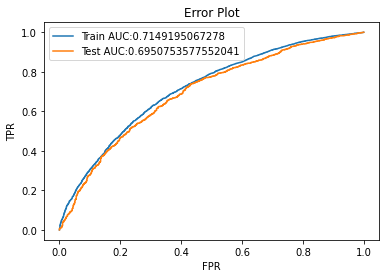

In [9]:
fpr1_fs, tpr1_fs, thresholds1_fs = roc_curve(y_train, y_final_train)
fpr2_fs, tpr2_fs, thresholds2_fs = roc_curve(y_test, y_final_test)

plt.figure()
plt.plot(fpr1_fs, tpr1_fs, label='Train AUC:'+str(auc(fpr1_fs,tpr1_fs)))
plt.plot(fpr2_fs, tpr2_fs, label='Test AUC:'+str(auc(fpr2_fs,tpr2_fs)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Error Plot')
plt.show()

In [10]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print('The maximum value of tpr*(1-fpr)', max(tpr*(1-fpr)), 'for threshold', np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [12]:
best_t = find_best_threshold(thresholds1_fs, fpr1_fs, tpr1_fs)

print('Train confusion matrix:')
print(confusion_matrix(y_train, predict_with_best_t(y_final_train, best_t)))
print('Test confusion matrix:')
print(confusion_matrix(y_test, predict_with_best_t(y_final_test, best_t)))

The maximum value of tpr*(1-fpr) 0.438747185061532 for threshold 0.488
Train confusion matrix:
[[ 2009  1034]
 [ 5688 11269]]
Test confusion matrix:
[[ 528  233]
 [1746 2493]]


In [13]:
# https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
def plotConfusionMatrix(matrix):
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Rejected','Accepted'])
    ax.yaxis.set_ticklabels(['Rejected','Accepted'])

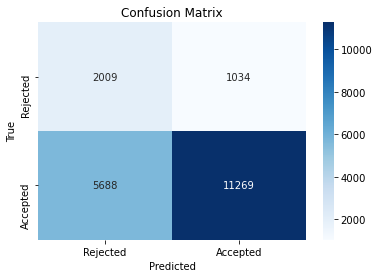

In [14]:
train_matrix = confusion_matrix(y_train, predict_with_best_t(y_final_train, best_t))
plotConfusionMatrix(train_matrix)

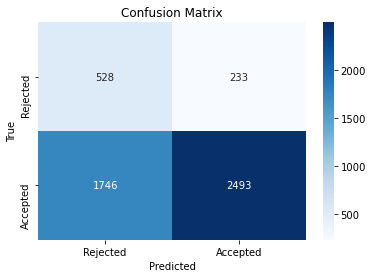

In [15]:
test_matrix = confusion_matrix(y_test, predict_with_best_t(y_final_test, best_t))
plotConfusionMatrix(test_matrix)

In [16]:
table = PrettyTable()
table.field_names=('Vectorizer', 'Hyper-Parameter', 'AUC')
table.add_row(['Log Reg with Feature Selection',str('C: '+str(log_reg.best_params_['C'])), auc(fpr2_fs,tpr2_fs)])
print(table)

+--------------------------------+-----------------+--------------------+
|           Vectorizer           | Hyper-Parameter |        AUC         |
+--------------------------------+-----------------+--------------------+
| Log Reg with Feature Selection |    C: 1000000   | 0.6950753577552041 |
+--------------------------------+-----------------+--------------------+
